In [3]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import numpy as np

In [4]:
data = pd.read_csv("./data/meia_data.csv")
data = data.drop(columns=["Town","Region","Type"])

## 1. Descripcion del Corpus

In [5]:
documentos = data["Review"].tolist()
corpus = " ".join(documentos)
n = len(documentos)

In [6]:
tokenizer = RegexpTokenizer(r'[a-zA-ZáéíóúñÁÉÍÓÚÑ]+')
doc_tokens = [tokenizer.tokenize(doc) for doc in documentos]
tokens = [token for token in tokenizer.tokenize(corpus)]
vocab = set(tokens)
print(f"Numero de documentos: {n}")
print(f"Numero de tokens en el corpus: {len(tokens)}")
print(f"Numero de palabras en el vocabulario: {len(vocab)}")


Numero de documentos: 5000
Numero de tokens en el corpus: 350871
Numero de palabras en el vocabulario: 22319


In [7]:
# Punto 2
# Hapax legomena y su proporcion.
fdist = FreqDist(tokens)
hapax_legomena = [word for word, freq in fdist.items() if freq == 1]
print(f"Numero de hapax legomena: {len(hapax_legomena)}")
print(f"Proporcion de hapax legomena con el vocabulario: {len(hapax_legomena) / len(vocab) * 100 if vocab else 0:.3f}%")


Numero de hapax legomena: 11671
Proporcion de hapax legomena con el vocabulario: 52.292%


In [8]:
## Parte 3. Porcentaje de stopwords
from nltk.corpus import stopwords

spanish_stopwords = set(stopwords.words('spanish'))

contador_stopwords = 0

stopwords_corpus = set()

for token in tokens:
    if token.lower() in spanish_stopwords:
        contador_stopwords += 1
        stopwords_corpus.add(token.lower())

print(f"Numero de stopwords: {contador_stopwords}")
print(f"Numero de stopwords en el vocabulario: {len(stopwords_corpus)}")
print(f"Porcentaje de stopwords: {contador_stopwords / len(tokens) * 100 if tokens else 0:.3f}%")

Numero de stopwords: 176729
Numero de stopwords en el vocabulario: 229
Porcentaje de stopwords: 50.369%


In [7]:
## Parte 4. Estadisticas por clase
for polarity in sorted(data['Polarity'].unique()):
    df_reducido = data.loc[data['Polarity'] == polarity, 'Review'].tolist()
    corpus_reducido = ' '.join(df_reducido)
    n = len(df_reducido)
    tokens_r = tokenizer.tokenize(corpus_reducido)
    vocab_r = set(tokens_r)

    print(f"Estadisticas para la polaridad {polarity}:")
    print(f" - Cantidad de textos: {n}")
    print(f" - Cantidad de palabras: {len(tokens_r)}")
    print(f" - Cantidad de palabras en el vocabulario: {len(vocab_r)}")

Estadisticas para la polaridad 1.0:
 - Cantidad de textos: 800
 - Cantidad de palabras: 62249
 - Cantidad de palabras en el vocabulario: 8609
Estadisticas para la polaridad 2.0:
 - Cantidad de textos: 900
 - Cantidad de palabras: 75380
 - Cantidad de palabras en el vocabulario: 9323
Estadisticas para la polaridad 3.0:
 - Cantidad de textos: 1000
 - Cantidad de palabras: 69868
 - Cantidad de palabras en el vocabulario: 8444
Estadisticas para la polaridad 4.0:
 - Cantidad de textos: 1100
 - Cantidad de palabras: 68992
 - Cantidad de palabras en el vocabulario: 8204
Estadisticas para la polaridad 5.0:
 - Cantidad de textos: 1200
 - Cantidad de palabras: 74382
 - Cantidad de palabras en el vocabulario: 9334


## 2. Ley de Zipf

In [8]:
## Calcular la frecuencia absoluta de cada palabra en el corpus y asignar rango
palabras = []
rango = list(range(1, len(fdist) + 1))
for palabra, _ in sorted(fdist.items(), key=lambda item: item[1], reverse=True):
    palabras.append(palabra)
    
freq_palabras = [fdist[palabra] for palabra in palabras]

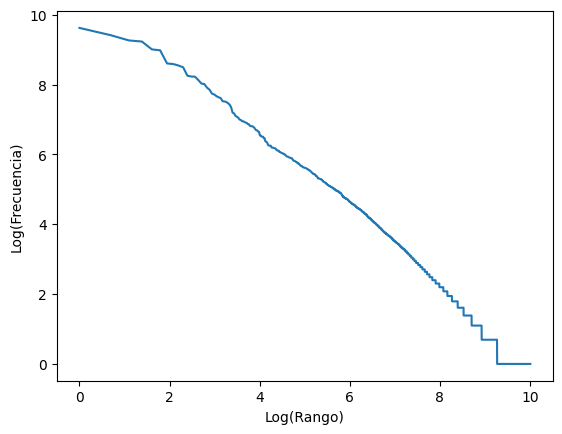

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

log_freq_palabras = np.log(freq_palabras)
log_ranking = np.log(rango)

fig, ax = plt.subplots()

sns.lineplot(x=log_ranking, y=log_freq_palabras, ax=ax)
ax.set_xlabel("Log(Rango)")
ax.set_ylabel("Log(Frecuencia)")
plt.savefig("./figures/zipf_law.pdf", bbox_inches='tight')

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linreg = LinearRegression()
linreg.fit(log_ranking.reshape(-1, 1), log_freq_palabras.reshape(-1, 1))

m = linreg.coef_[0][0]
b = linreg.intercept_[0]
print(f"Pendiente: {m}, Interseccion: {b}")

Pendiente: -1.2334549048028804, Interseccion: 11.982853383709413


In [11]:
y_reg = linreg.predict(log_ranking.reshape(-1,1))

In [12]:
print(f"R^2: {r2_score(log_freq_palabras, y_reg.flatten())}")

R^2: 0.9714861597261958


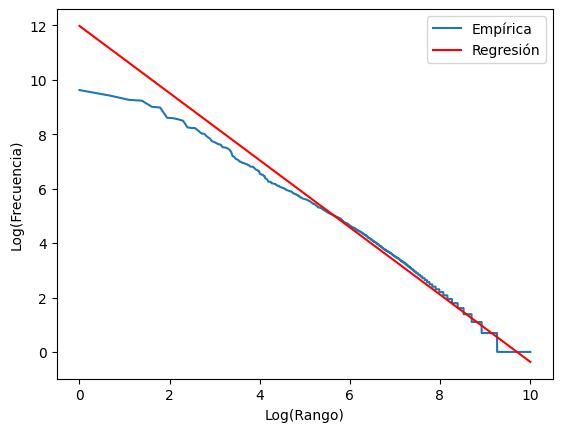

In [13]:
fig, ax = plt.subplots()

sns.lineplot(x=log_ranking, y=log_freq_palabras, ax=ax, label="Empírica")
ax.set_xlabel("Log(Rango)")
ax.set_ylabel("Log(Frecuencia)")
sns.lineplot(x=log_ranking, y=y_reg.flatten(), color='red', ax=ax, label="Regresión")

plt.savefig("./figures/zipf_law_regression.pdf", bbox_inches='tight')

In [14]:
m

-1.2334549048028804

In [15]:
C = np.exp(b)
s = -m

print(f"Constante de normalizacion: {C}. Frecuencia de la palabra mas comun: {fdist[palabras[0]]}")

print(f"Exponente de la ley de Zipf: {s}")


### Discutir por que.

Constante de normalizacion: 159987.88677750676. Frecuencia de la palabra mas comun: 15131
Exponente de la ley de Zipf: 1.2334549048028804


## 3. Palabras importantes por clase

In [16]:
def normalizar_texto(texto:str) -> str:
    texto = texto.lower()
    tokens = tokenizer.tokenize(texto)
    tokens_normalizados = [token for token in tokens if token not in spanish_stopwords]
    return " ".join(tokens_normalizados)

data_normalizada = data.copy()
data_normalizada["Review"] = data_normalizada["Review"].apply(normalizar_texto)


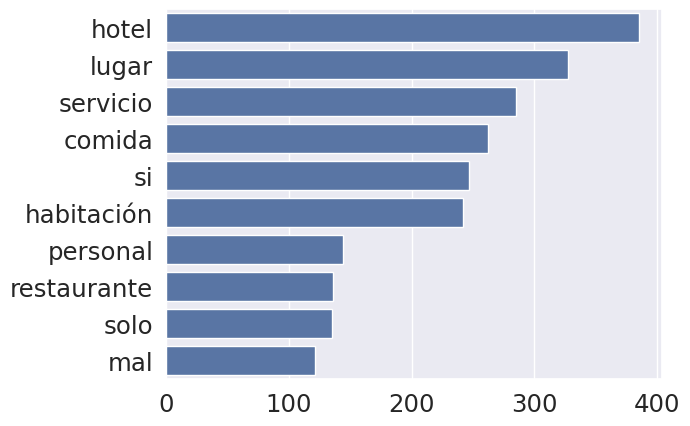

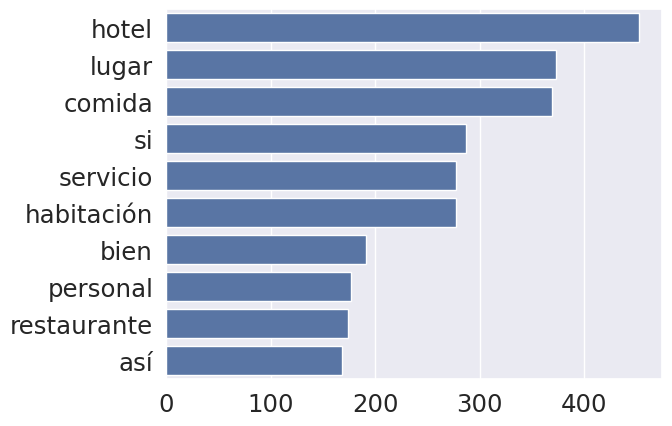

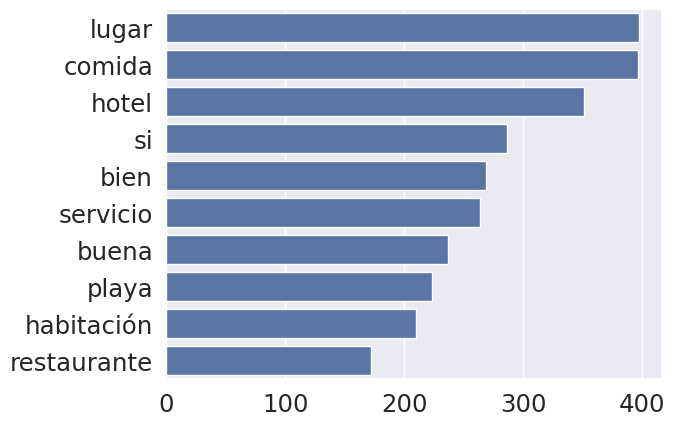

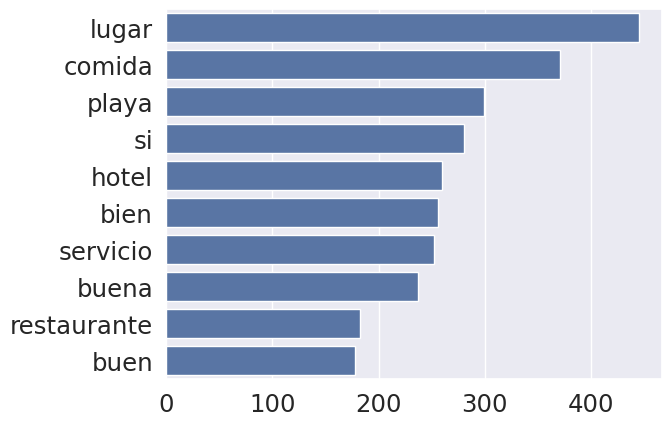

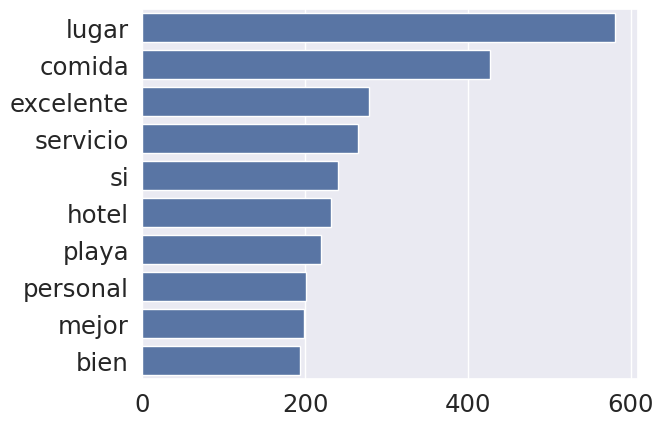

In [17]:
# Palabras mas utilizadas por clase

font = {'fontsize': 18, 'fontweight': 'medium', 'family': 'serif'}

sns.set_theme(font_scale=1.6)

for clase in sorted(data_normalizada["Polarity"].unique()):
    corpus_r = data_normalizada.loc[data_normalizada["Polarity"] == clase,"Review"].tolist()
    
    tokens_r = [word for review in corpus_r for word in tokenizer.tokenize(review)]
    freq = FreqDist(tokens_r)

    palabra_array = []
    frecuencia_array = []
    for palabra, frecuencia in freq.most_common(10):
        palabra_array.append(palabra)
        frecuencia_array.append(frecuencia)

    sns.barplot(x=frecuencia_array, y=palabra_array, orient="h")
    plt.savefig(f"./figures/palabras_comunes_clase_{clase:.0f}.pdf", bbox_inches='tight', dpi=400)
    plt.show()


## 4. Patrones gramaticales (POS tagging)

In [18]:
import spacy
#!python -m spacy download es_core_news_sm
nlp = spacy.load("es_core_news_sm")

In [19]:
def aplicar_pos_tagging(texto):
    doc = nlp(texto)
    return " ".join([token.pos_ for token in doc])

# Utilizamos el corpus sin preprocesar para mantener la gramatica.
data["pos"] = data["Review"].apply(aplicar_pos_tagging)

In [20]:
def get_ngrams(text, n=4):
    """
    Toma una cadena de texto, la divide en tokens y devuelve una lista de n-gramas.
    """
    tokens = text.split()
    if len(tokens) < n:
        return []
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [21]:
from itertools import chain
from collections import Counter

data["tetragram"] = data["pos"].apply(lambda x: get_ngrams(x, n=4))

In [22]:
# Obtener los tetragramas más comunes para cada clase
class_counts = {}
for cls in sorted(data['Polarity'].unique()):
    class_df = data[data['Polarity'] == cls]

    all_tetragrams = list(chain.from_iterable(class_df['tetragram']))
    counter = Counter(all_tetragrams)
    class_counts[cls] = counter.most_common(5)
    
for cls, common_tetragrams in class_counts.items():
    print(f"\nLos 5 tetragramas más comunes para la clase {cls:.0f} son:")
    for tetragram, count in common_tetragrams:
        print(f"- '{tetragram}' : {count} veces")


Los 5 tetragramas más comunes para la clase 1 son:
- 'NOUN ADP DET NOUN' : 817 veces
- 'ADP DET NOUN PUNCT' : 772 veces
- 'VERB ADP DET NOUN' : 683 veces
- 'DET NOUN ADP NOUN' : 670 veces
- 'ADP DET NOUN ADP' : 524 veces

Los 5 tetragramas más comunes para la clase 2 son:
- 'NOUN ADP DET NOUN' : 1145 veces
- 'ADP DET NOUN PUNCT' : 977 veces
- 'DET NOUN ADP NOUN' : 869 veces
- 'DET NOUN ADP DET' : 762 veces
- 'ADP DET NOUN ADP' : 746 veces

Los 5 tetragramas más comunes para la clase 3 son:
- 'NOUN ADP DET NOUN' : 1070 veces
- 'ADP DET NOUN PUNCT' : 902 veces
- 'DET NOUN ADP NOUN' : 830 veces
- 'DET NOUN ADP DET' : 701 veces
- 'ADP DET NOUN ADP' : 678 veces

Los 5 tetragramas más comunes para la clase 4 son:
- 'NOUN ADP DET NOUN' : 1095 veces
- 'ADP DET NOUN PUNCT' : 890 veces
- 'DET NOUN ADP NOUN' : 839 veces
- 'ADP DET NOUN ADP' : 781 veces
- 'DET NOUN ADP DET' : 716 veces

Los 5 tetragramas más comunes para la clase 5 son:
- 'NOUN ADP DET NOUN' : 1080 veces
- 'ADP DET NOUN PUNCT' : 

## 5. Representaciones BoW

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vectorizer = TfidfVectorizer()
count_vectorizer = CountVectorizer()

In [24]:
X_tfidf = tfidf_vectorizer.fit_transform(data["Review"]).toarray()
X_tf = count_vectorizer.fit_transform(data["Review"]).toarray()
y = data["Polarity"].values

In [25]:
tfidf_features = tfidf_vectorizer.get_feature_names_out()
tf_features = count_vectorizer.get_feature_names_out()

In [26]:
X_tfidf.shape

(5000, 19970)

In [27]:
from sklearn.feature_selection import chi2

def get_chi2_n_mi(X, y):
    chi2_scores, p_values = chi2(X, y)

    return chi2_scores, p_values

In [28]:
tf_chi2, tf_p = get_chi2_n_mi(X_tf, y)
tfidf_chi2, tfidf_p = get_chi2_n_mi(X_tfidf, y)

In [29]:
from sklearn.feature_selection import SelectKBest

# Select the top 20 features using Chi-Squared
k = 20

tf_selector_chi2 = SelectKBest(chi2, k=k)
X_new_chi2 = tf_selector_chi2.fit_transform(X_tf, y)

tfidf_selector_chi2 = SelectKBest(chi2, k=k)
X_new_tfidf_chi2 = tfidf_selector_chi2.fit_transform(X_tfidf, y)

# Get the indices of the selected features
tf_selected_features_indices = tf_selector_chi2.get_support(indices=True)
tfidf_selected_features_indices = tfidf_selector_chi2.get_support(indices=True)

# Map indices back to feature names
top_features_tf_chi2 = [tf_features[i] for i in tf_selected_features_indices]
top_features_tfidf_chi2 = [tfidf_features[i] for i in tfidf_selected_features_indices]

print(f"Top {k} features by Chi-Squared (TF): {top_features_tf_chi2}")
print(f"Top {k} features by Chi-Squared (TF-IDF): {top_features_tfidf_chi2}")

Top 20 features by Chi-Squared (TF): ['cuando', 'dijeron', 'excelente', 'habitación', 'había', 'hotel', 'increíble', 'la', 'mal', 'mala', 'me', 'nada', 'ni', 'no', 'nos', 'peor', 'pero', 'por', 'pésimo', 'que']
Top 20 features by Chi-Squared (TF-IDF): ['buen', 'deliciosa', 'dijeron', 'excelente', 'gracias', 'habitación', 'horrible', 'increíble', 'mal', 'mala', 'nada', 'ni', 'no', 'peor', 'pero', 'pésima', 'pésimo', 'que', 'regular', 'terrible']


In [30]:
contador_tf = 0
contador_tfidf = 0

for i in range(20):
    if top_features_tf_chi2[i] in spanish_stopwords:
        contador_tf += 1
    if top_features_tfidf_chi2[i] in spanish_stopwords:
        contador_tfidf += 1

print(f"Stopwords TF: {contador_tf}")
print(f"Stopwords TF-IDF: {contador_tfidf}")


Stopwords TF: 11
Stopwords TF-IDF: 5


## 6. Bigramas

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2))
count_vectorizer = CountVectorizer(ngram_range=(2,2))

In [32]:
X_tfidf = tfidf_vectorizer.fit_transform(data["Review"]).toarray()
X_tf = count_vectorizer.fit_transform(data["Review"]).toarray()
y = data["Polarity"].values

In [33]:
tfidf_features = tfidf_vectorizer.get_feature_names_out()
tf_features = count_vectorizer.get_feature_names_out()

In [34]:
tf_chi2, tf_p = get_chi2_n_mi(X_tf, y)
tfidf_chi2, tfidf_p = get_chi2_n_mi(X_tfidf, y)

In [35]:
from sklearn.feature_selection import SelectKBest

# Select the top 20 features using Chi-Squared
k = 20

tf_selector_chi2 = SelectKBest(chi2, k=k)
X_new_chi2 = tf_selector_chi2.fit_transform(X_tf, y)

tfidf_selector_chi2 = SelectKBest(chi2, k=k)
X_new_tfidf_chi2 = tfidf_selector_chi2.fit_transform(X_tfidf, y)

# Get the indices of the selected features
tf_selected_features_indices = tf_selector_chi2.get_support(indices=True)
tfidf_selected_features_indices = tfidf_selector_chi2.get_support(indices=True)

# Map indices back to feature names
top_features_tf_chi2 = [tf_features[i] for i in tf_selected_features_indices]
top_features_tfidf_chi2 = [tfidf_features[i] for i in tfidf_selected_features_indices]

print(f"Top {k} features by Chi-Squared (TF): {top_features_tf_chi2}")
print(f"Top {k} features by Chi-Squared (TF-IDF): {top_features_tfidf_chi2}")

Top 20 features by Chi-Squared (TF): ['dijeron que', 'dijo que', 'este hotel', 'excelente servicio', 'la habitación', 'las ruinas', 'me dijeron', 'muy mal', 'muy mala', 'ni siquiera', 'no es', 'no había', 'no hay', 'no lo', 'nos dijeron', 'pero no', 'pésimo servicio', 'que no', 'sin embargo', 'un poco']
Top 20 features by Chi-Squared (TF-IDF): ['comida deliciosa', 'comida no', 'dijeron que', 'dijo que', 'el peor', 'es buena', 'excelente servicio', 'la habitación', 'mal servicio', 'mala experiencia', 'muy mal', 'muy mala', 'ni siquiera', 'no es', 'no había', 'no lo', 'nos dijeron', 'pésimo servicio', 'sin embargo', 'un poco']


In [36]:
contador_tf = 0
contador_tfidf = 0

for i in range(20):
    
    if top_features_tf_chi2[i].split()[0] in spanish_stopwords:
        contador_tf += 1
    if top_features_tf_chi2[i].split()[1] in spanish_stopwords:
        contador_tf += 1
    if top_features_tfidf_chi2[i].split()[0] in spanish_stopwords:
        contador_tfidf += 1
    if top_features_tfidf_chi2[i].split()[1] in spanish_stopwords:
        contador_tfidf += 1

print(f"Stopwords TF: {contador_tf}")
print(f"Stopwords TF-IDF: {contador_tfidf}")

Stopwords TF: 25
Stopwords TF-IDF: 19


In [37]:
intr = set(top_features_tf_chi2).intersection(set(top_features_tfidf_chi2))
len(intr)

solo_tf = set(top_features_tf_chi2) - set(top_features_tfidf_chi2)
solo_tfidf = set(top_features_tfidf_chi2) - set(top_features_tf_chi2)

print(f"Solo en TF: {solo_tf}")
print(f"Solo en TF-IDF: {solo_tfidf}")

Solo en TF: {'las ruinas', 'pero no', 'me dijeron', 'este hotel', 'que no', 'no hay'}
Solo en TF-IDF: {'es buena', 'comida no', 'mal servicio', 'mala experiencia', 'el peor', 'comida deliciosa'}


## 7. Word2Vec y analogias

In [9]:
from gensim.models import Word2Vec

In [12]:
w2v = Word2Vec(sentences=doc_tokens, vector_size=75, window=2, sg=1, seed=1)

In [13]:
def get_analogies(model: Word2Vec, positive, negative):
    """
    Obtiene las palabras más similares a una palabra dada, utilizando un modelo de Word2Vec.
    """
    return model.wv.most_similar(positive=positive, negative=negative)


In [17]:
analogies = get_analogies(w2v, positive=['habitacion','restaurante'], negative=['hotel'])
print(analogies)

[('bebida', 0.8704158663749695), ('carta', 0.8500247597694397), ('cocina', 0.8489914536476135), ('chica', 0.8463365435600281), ('mesera', 0.8459905385971069), ('bienvenida', 0.8458359241485596), ('camarera', 0.8409348130226135), ('pizza', 0.8389284014701843), ('actividad', 0.8338670134544373), ('temperatura', 0.8333542346954346)]


In [18]:
analogies = get_analogies(w2v, positive=['mesa','hotel'], negative=['restaurante'])
print(analogies)

[('reservado', 0.8062992691993713), ('llevaron', 0.8027639389038086), ('tercera', 0.7896162271499634), ('pusieron', 0.786984384059906), ('ventana', 0.7868624925613403), ('puerta', 0.7781004905700684), ('reservación', 0.7772968411445618), ('asignaron', 0.7714852094650269), ('llegada', 0.7702041268348694), ('tarjeta', 0.7677271366119385)]


In [21]:
analogies = get_analogies(w2v, positive=['deliciosa','platillo'], negative=None)
print(analogies)

[('sencilla', 0.971453070640564), ('auténtica', 0.968036413192749), ('decente', 0.9661558866500854), ('barata', 0.964105486869812), ('variada', 0.9640276432037354), ('exquisita', 0.9634297490119934), ('regional', 0.9617670774459839), ('original', 0.9610365629196167), ('Peña', 0.9564813375473022), ('casera', 0.9562150835990906)]


## 8. Embeddings de documento y clusterizacion

In [ ]:
def doc2vec(doc, w2v):
    """Takes tokenized document to vector representation."""
    word_vectors = np.array([w2v.wv[word] for word in doc if word in w2v.wv])
    return word_vectors.mean(axis=0)

doc_vectors = np.array([doc2vec(doc, w2v) for doc in doc_tokens])

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(doc_vectors)


In [ ]:
centroides = kmeans.cluster_centers_
centroides.shape

In [ ]:
dist_centroides = np.zeros((5000,5))
for i, doc_vec in enumerate(doc_vectors):
    for j in range(5):
        dist_centroides[i, j] = np.linalg.norm(doc_vec - centroides[j])

doc_mas_cercanos = np.argmin(dist_centroides, axis=0)

In [ ]:
doc_mas_cercanos

In [ ]:
print("Documentos mas cercanos a cada centroide:")
for i, doc in enumerate(doc_mas_cercanos):
    print(f"\n- Centroide {i}\nPolaridad: {data.loc[doc, 'Polarity']}\nDocumento:\n{documentos[doc]}")

## 9. Clasificacion con particion 70/30

In [ ]:
labels = data["Polarity"].astype(int).values
labels

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)

def evaluar_bow(BOW_train, BOW_test, val_y, tr_y):
    # Parámetro de complejidad del SVM, se proponen estos
    # y se recorrerán con GridSearch
    parameters = {"C": [.05, .12, .25, .5, 1, 2, 4]}
    # Tratar de penalizar con base a la proporción de ejemplos
    # en cada clase
    svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)
    grid = GridSearchCV(estimator=svr, param_grid=parameters,
                        n_jobs=6, scoring="f1_macro", cv=5)
    grid.fit(BOW_train, tr_y)
    y_pred = grid.predict(BOW_test)

    confusion = "\n" + str(confusion_matrix(val_y, y_pred))
    class_report = "\n" + classification_report(val_y, y_pred, digits=3)

    return {
        "confusion_matrix": confusion,
        "classification_report": class_report
    }



x_train_index, x_test_index, y_train, y_test = train_test_split(
    np.arange(len(doc_vectors)), labels, test_size=0.3, random_state=42, stratify=labels
)

### a) Sin preprocesamiento.

In [ ]:
# w2v vectors de tokens sin preprocesar = doc_vectors
X_train = doc_vectors[x_train_index]
X_test = doc_vectors[x_test_index]

y_train = labels[x_train_index]
y_test = labels[x_test_index]

In [ ]:
metrics = evaluar_bow(X_train, X_test, y_test, y_train)

In [ ]:
for metric, value in metrics.items():
    print(f"{metric}: {value}")

### b) Con minusculas.

In [ ]:
# Creamos documentos en minusculas y sin stopwords
documentos_minusculas = [doc.lower() for doc in documentos]
documentos_minusculas_stp = [" ".join([token for token in doc.split() if token not in spanish_stopwords]) for doc in documentos_minusculas]

# Creamos tokenss
doc_min_tokens = [tokenizer.tokenize(doc) for doc in documentos_minusculas_stp]

# Creamos el modelo word2vec con el tokenizado/preprocesado anterior
w2v_min_tokens = Word2Vec(sentences=doc_min_tokens, vector_size=50, window=2, sg=1, seed=1)

doc_min_w2v = np.array([doc2vec(doc, w2v_min_tokens) for doc in doc_min_tokens])

In [ ]:
X_train = doc_min_w2v[x_train_index]
X_test = doc_min_w2v[x_test_index]
y_train = labels[x_train_index]
y_test = labels[x_test_index]

In [ ]:
metrics = evaluar_bow(X_train, X_test, y_test, y_train)

In [ ]:
for metric, value in metrics.items():
    print(f"{metric}: {value}")

### c) Minusculas, stemming/lematizacion

In [ ]:
# import spanish stemmer
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("spanish")

In [ ]:
doc_min_stem_tokens = [[stemmer.stem(token) for token in doc] for doc in doc_min_tokens]

w2v_min_stem = Word2Vec(sentences=doc_min_stem_tokens, vector_size=50, window=2, sg=1, seed=1)

doc_min_stem_w2v = np.array([doc2vec(doc, w2v_min_stem) for doc in doc_min_stem_tokens])

In [ ]:
X_train = doc_min_stem_w2v[x_train_index]
X_test = doc_min_stem_w2v[x_test_index]
y_train = labels[x_train_index]
y_test = labels[x_test_index]

metrics = evaluar_bow(X_train, X_test, y_test, y_train)

for metric, value in metrics.items():
    print(f"{metric}: {value}")

### d) minusculas, stemming, y filtrado de palabras con frecuencia minima de 10

In [ ]:
corpus_min_stem = [token for doc_token in doc_min_stem_tokens for token in doc_token]
fdist = FreqDist(corpus_min_stem)
invalid_tokens = set([token for token, freq in fdist.items() if freq < 10])

In [ ]:
doc_min_stem_freq_tokens = [[token for token in doc if token not in invalid_tokens] for doc in doc_min_stem_tokens]

w2v_min_stem_freq = Word2Vec(sentences=doc_min_stem_freq_tokens, vector_size=50, window=2, sg=1, seed=1)

doc_min_stem_freq_w2v = np.array([doc2vec(doc, w2v_min_stem_freq) for doc in doc_min_stem_freq_tokens])

In [ ]:
X_train = doc_min_stem_freq_w2v[x_train_index]
X_test = doc_min_stem_freq_w2v[x_test_index]
y_train = labels[x_train_index]
y_test = labels[x_test_index]

metrics = evaluar_bow(X_train, X_test, y_test, y_train)

for metric, value in metrics.items():
    print(f"{metric}: {value}")

## 10. LSA con 50 topicos

### Building the matrix W

In [ ]:
# -*- coding: utf-8 -*-
from collections import Counter
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


# -----------------------------
# 1) Preprocesamiento y vocabulario
# -----------------------------
def construir_vocab(corpus_tokens, min_count=1):
    """
    Construye vocabulario a partir de una lista de listas de tokens.
    min_count: frecuencia mínima para incluir palabra en el vocabulario.
    """
    freqs = Counter()
    for tokens in corpus_tokens:
        freqs.update(tokens)
    vocab = [w for w, c in freqs.items() if c >= min_count]
    vocab.sort()  # orden estable
    word2id = {w: i for i, w in enumerate(vocab)}
    return vocab, word2id

In [ ]:
# -----------------------------
# 2) Matriz de coocurrencia W
# -----------------------------
def matriz_coocurrencia(corpus, tokenizer = RegexpTokenizer(r"\b\w+\b"), window_size=2, min_count=1, directed=True):
    """
    Construye la matriz W (palabra objetivo x palabra contexto).
    - window_size: tamaño de la ventana simétrica alrededor del target.
    - directed=True: solo cuenta (i -> j). Si False, también suma (j -> i).
    Devuelve: (W_csr, vocab, word2id)
    """
    # Tokenizar corpus
    corpus_tokens = [tokenizer.tokenize(doc) for doc in corpus]
    # Vocabulario
    vocab, word2id = construir_vocab(corpus_tokens, min_count=min_count)
    V = len(vocab)

    rows, cols, data = [], [], []

    for tokens in corpus_tokens:
        ids = [word2id[w] for w in tokens if w in word2id]
        n = len(ids)
        for i, wi in enumerate(ids):
            # ventana [i-window_size, i+window_size], excluyendo i
            left = max(0, i - window_size)
            right = min(n, i + window_size + 1)
            for j in range(left, right):
                if i == j:
                    continue
                wj = ids[j]
                # cuenta ocurrencia en el contexto
                rows.append(wi)
                cols.append(wj)
                data.append(1.0)
                # si quieres matriz estrictamente simétrica, puedes sumar también el espejo
                if not directed:
                    rows.append(wj)
                    cols.append(wi)
                    data.append(1.0)

    if not rows:
        # corpus vacío o vocabulario filtrado demasiado estricto
        W = csr_matrix((V, V), dtype=np.float64)
    else:
        W = coo_matrix((np.array(data, dtype=np.float64),
                        (np.array(rows), np.array(cols))), shape=(V, V)).tocsr()

    return W, vocab, word2id



In [ ]:
# -----------------------------
# 3) LSA vía SVD truncado
# -----------------------------
def lsa_embeddings(W, k=10, random_state=0):
    """
    Aplica SVD truncado a W:
        W ≈ U_k Σ_k V_k^T
    TruncatedSVD.fit_transform(W) ≈ U_k Σ_k  (embeddings de filas/palabras objetivo)
    Devuelve: X (V x k) con embeddings densos.
    """
    k = min(k, min(W.shape) - 1)  # seguridad
    svd = TruncatedSVD(n_components=k, random_state=random_state)
    X = svd.fit_transform(W)  # U_k Σ_k
    return X, svd

In [ ]:
# -----------------------------
# 4) Utilidades: similitud de palabras
# -----------------------------
def similitud_palabras(palabra, vocab, X, topk=10):
    """
    Devuelve top-k palabras más similares (coseno) a 'palabra'
    usando los embeddings X.
    """
    if palabra not in vocab:
        raise ValueError(f"'{palabra}' no está en el vocabulario.")
    idx = vocab.index(palabra)
    v = X[idx:idx+1]  # (1, k)
    sims = cosine_similarity(v, X).flatten()  # (V,)
    # ordenar por similitud decreciente; ignorar índice de la propia palabra
    orden = np.argsort(-sims)
    vecinos = [(vocab[i], float(sims[i])) for i in orden if i != idx][:topk]
    return vecinos

In [ ]:
print(documentos)